In [1]:
import glob
import json
import os
import time

import detectron2
from detectron2.checkpoint import DetectionCheckpointer
from detectron2.config import get_cfg
from detectron2.data import build_detection_test_loader
from detectron2.modeling import build_model
from detectron2.utils.visualizer import Visualizer
import matplotlib.pyplot as plt
import numpy as np
import torch

ungulates_root = os.path.dirname(os.path.dirname(os.getcwd()))
local_paths_file = os.path.join(ungulates_root, 'local-paths.json')
with open(local_paths_file, "r") as json_file:
    local_paths = json.load(json_file)

import sys
sys.path.append(local_paths['overhead_functions_path'])

from detectron2_classes.DetectionDatasetMapper import DetectionDatasetMapper
from inference import register_inference_instances, draw_detections
import koger_general_functions as kgf

In [2]:
# Name of model folder to use for inference
model_name = "full-resolution-model_maxiter-133600_lr-0.0019_detectPerIm-200_minsize-0_batchsize-8"

In [3]:
# name of observation to visualize
observation_name = "observation088"

# ---------------------------------------
# Automatic image loading based on specific file structure of multi-drone observations
frame_folders_root = os.path.join(local_paths['base_frames_folder'], observation_name)
frame_files = kgf.get_observation_frame_files(frame_folders_root)

# Replace with however you want to choose frames
frame_files = np.random.choice(frame_files, 2)

In [4]:
# Load model and modify config for inference
models_folder = os.path.join(os.path.dirname(os.getcwd()), 
                             'model-training', 'output')
yaml_file = os.path.join(models_folder, model_name, 'config.yaml')

cfg = get_cfg()

with open(yaml_file, 'r') as f:
    yaml_string = f.read()
cfg = cfg.load_cfg(yaml_string)

cfg.INPUT.CROP.ENABLED = False

weights_path = sorted(
    glob.glob(os.path.join(models_folder, model_name, 
                           "best-model-config-iter-*.pth"))
)
cfg.MODEL.WEIGHTS = weights_path[-1]
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5

In [5]:
# Use all paths in frame_files for inference
register_inference_instances("inference", frame_files)
mapper = DetectionDatasetMapper(cfg, is_train=False)
loader = build_detection_test_loader(cfg, "inference", mapper=mapper)

In [6]:
# build the model
model = build_model(cfg)
_ = model.eval()

checkpointer = DetectionCheckpointer(model)
_ = checkpointer.load(cfg.MODEL.WEIGHTS)

/home/golden/detectron2aug16/lib/python3.6/site-packages/detectron2/layers/wrappers.py:226: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)
  return x.nonzero().unbind(1)


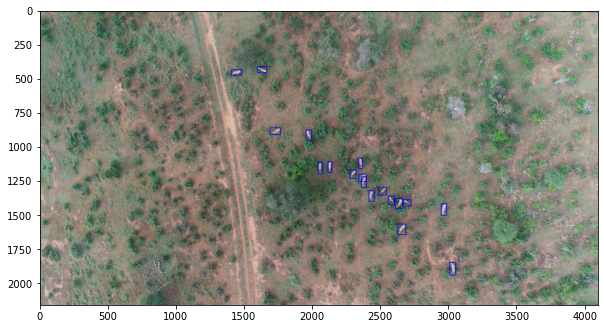

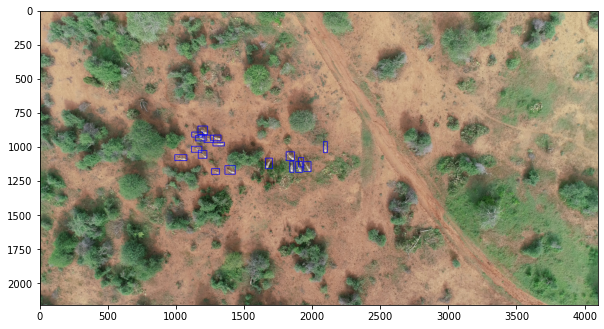

In [7]:
all_detections = []

colors = [(0, 0, 255), (255, 193, 7), (255, 255, 255)]

with torch.no_grad():
    for batch_num, image_batch in enumerate(loader):
        detections = model(image_batch)
        for detection, im in zip(detections, image_batch):
            instances = detection['instances']
            im = draw_detections(im, instances, min_score=.3, colors=colors)
            plt.figure(figsize=(10,10))
            plt.imshow(im)